In [19]:
df = pd.read_csv("cleaned_review.csv")

In [20]:
df.head(2)

,review,label
0,The movie is vulgar and not meant for children...,Negative
1,This book did not move me at all. The plot is ...,Negative


In [21]:
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

Processing of data

In [22]:
df['review'] = df['review'].apply(lambda x: x.lower())

In [23]:
!pip install emojipy

In [24]:
import re
import json

In [25]:
with open("final_acronyms.json", "r") as file:
    dictionary = json.load(file)
final_dict = {k.lower(): v.lower() for k, v in dictionary.items()}

In [26]:
with open("emojis_config.json", "r") as file:
    emoji_to_word = json.load(file)

In [27]:
from emojipy import Emoji
import re

emoji = Emoji()

def emoji_to_words(text):
    shortcoded = emoji.unicode_to_shortcode(text)
    shortcoded = re.sub(r'(:\w+?:)', r' \1 ', shortcoded).strip()
    parts = shortcoded.split()
    result = []
    for part in parts:
        result.append(emoji_to_word.get(part, part))
    temp_text=  ' '.join(result)
    return re.sub(r':(\w+):', r'\1', temp_text)

def remove_dup(text):
  cleaned_text = re.sub(r'\b(\w+)( \1\b)+', r'\1', text, flags=re.IGNORECASE)
  return cleaned_text

In [28]:
text = "Hello World 😂😊😊😊😊😊"
converted_text = remove_dup(emoji_to_words(text))
print("Converted to Text:", converted_text)

Converted to Text: Hello World joy blush


In [29]:
#checking word count before
word_count = df['review'].apply(lambda x: len(str(x).split())).sum()
word_count

np.int64(2271605)

In [30]:
def Transformation_Using_Knowledge_Base(df):
  df['review'] = df['review'].replace(final_dict, regex=True)

In [32]:
Transformation_Using_Knowledge_Base(df)

In [33]:
#checking word count after
word_count = df['review'].apply(lambda x: len(str(x).split())).sum()
word_count

np.int64(2525903)

Distribution Of Words

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

In [36]:
word_counts = df['review'].apply(lambda x : len(x.split()))

<Axes: xlabel='review', ylabel='Count'>

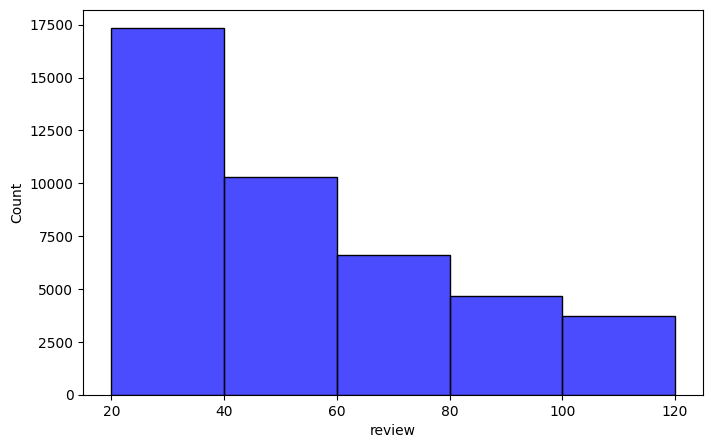

In [37]:
plt.figure(figsize=(8, 5))
sns.histplot(word_counts, bins=5, color='blue', alpha=0.7)

Assigning Sentiment Score Using Vader

In [ ]:
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 11.4 MB/s eta 0:00:00


In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [ ]:
sentiment_scores = df['review'].apply(analyzer.polarity_scores)

In [ ]:
df['Sentiment'] = sentiment_scores.apply(lambda x: x['compound'])

In [ ]:
df.head(2)

,review,label,Sentiment
0,The movie is vulgar and not meant for children...,Negative,-0.0788
1,This book did not move me at all. The plot is ...,Negative,-0.2755


BERT WORD EMBEDDINGS

In [ ]:
import torch
!pip install skrebate

  Preparing metadata (setup.py) ... done
  Created wheel for skrebate: filename=skrebate-0.62-py3-none-any.whl size=29256 sha256=46b0d9c7d94f9ec1897b7393d5db0230d2228b3f978a705c8a7972c015fef1a3
  Stored in directory: /root/.cache/pip/wheels/8a/d2/67/8368fca718041057b33d6448ca526aaf1ce2e404c94b901e41
Successfully built skrebate


In [ ]:
from transformers import BertTokenizer, BertModel
from skrebate import ReliefF
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

In [ ]:
MODEL_NAME = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
bert_model = BertModel.from_pretrained(MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model.to(device)
bert_model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [ ]:
class ReviewDataset(Dataset):
    def __init__(self, reviews):
        self.reviews = reviews

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        return self.reviews[idx]

In [ ]:
batch_size = 64
dataset = ReviewDataset(df['review'].tolist())
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [ ]:
all_embeddings = []
with torch.no_grad():
    for batch in dataloader:
        tokens = tokenizer(
            batch,
            max_length=512,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        ).to(device)

        outputs = bert_model(**tokens)
        cls_embeddings = outputs.last_hidden_state[:, 0, :]
        all_embeddings.append(cls_embeddings.cpu())

In [ ]:
all_embeddings = torch.cat(all_embeddings, dim=0)

In [ ]:
print(df.columns)

Index(['review', 'label', 'sentiment_1', 'confidence', 'Sentiment_2'], dtype='object')


In [ ]:
torch.save(all_embeddings, "embeddings.pt")

Reduce the BERT Dimensions

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from sklearn.decomposition import PCA
import pickle

In [ ]:
all_embeddings = torch.load("embeddings.pt")

In [ ]:
all_embeddings = torch.cat(all_embeddings, dim=0)

In [ ]:
tensor_flattened = all_embeddings.view(all_embeddings.size(0), -1)
pca = PCA(n_components=256)
pca_embeddings = pca.fit_transform(tensor_flattened.cpu().numpy())
embedding_df = pd.DataFrame(
    pca_embeddings,
    columns=[f'embedding_{i+1}' for i in range(pca_embeddings.shape[1])]
)
with open('pca_model.pkl', 'wb') as f:
    pickle.dump(pca, f)

In [ ]:
df.head(2)

,review,label,Sentiment
0,The movie is vulgar and not meant for children...,Negative,-0.0788
1,This book did not move me at all. The plot is ...,Negative,-0.2755


In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
labelEncoder = LabelEncoder()
y = labelEncoder.fit_transform(df['label'])

In [ ]:
df_reset = df["Sentiment"].reset_index(drop=True)
embedding_reset = embedding_df.reset_index(drop=True)

In [ ]:
X = pd.concat([df_reset, embedding_reset], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train = torch.tensor(X_train.values, dtype=torch.float32)
X_test = torch.tensor(X_test.values, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

LSTM CLASSIFIER


In [ ]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, num_layers=2, dropout=0.3, bidirectional=True):
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=bidirectional, dropout=dropout)
        num_directions = 2 if bidirectional else 1
        self.fc = nn.Linear(hidden_size * num_directions, num_classes)
        self.dropout = nn.Dropout(dropout)
        self.batch_norm = nn.BatchNorm1d(hidden_size * num_directions)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers * (2 if self.bidirectional else 1), batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * (2 if self.bidirectional else 1), batch_size, self.hidden_size).to(x.device)
        lstm_out, (hidden, _) = self.lstm(x, (h0, c0))
        if self.bidirectional:
            hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)
        else:
            hidden = hidden[-1]
        out = self.batch_norm(hidden)
        out = self.dropout(out)
        out = self.fc(out)
        return out

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
hidden_size = 512
learning_rate = 0.001
epochs = 10
model = LSTMClassifier(input_size=X_train.shape[1], hidden_size=hidden_size, num_classes=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [ ]:
train_losses = []
test_accuracies = []
all_predictions = []
all_labels = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_loader))

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.unsqueeze(1)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)
    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {running_loss / len(train_loader):.4f}, Test Accuracy: {accuracy:.2f}%")
    scheduler.step()

Epoch [1/10], Loss: 0.2899, Test Accuracy: 92.79%
Epoch [2/10], Loss: 0.2174, Test Accuracy: 93.22%
Epoch [3/10], Loss: 0.1943, Test Accuracy: 93.50%
Epoch [4/10], Loss: 0.1703, Test Accuracy: 93.16%
Epoch [5/10], Loss: 0.1469, Test Accuracy: 93.44%
Epoch [6/10], Loss: 0.1041, Test Accuracy: 93.72%
Epoch [7/10], Loss: 0.0829, Test Accuracy: 93.65%
Epoch [8/10], Loss: 0.0686, Test Accuracy: 93.67%
Epoch [9/10], Loss: 0.0569, Test Accuracy: 93.40%
Epoch [10/10], Loss: 0.0490, Test Accuracy: 93.56%


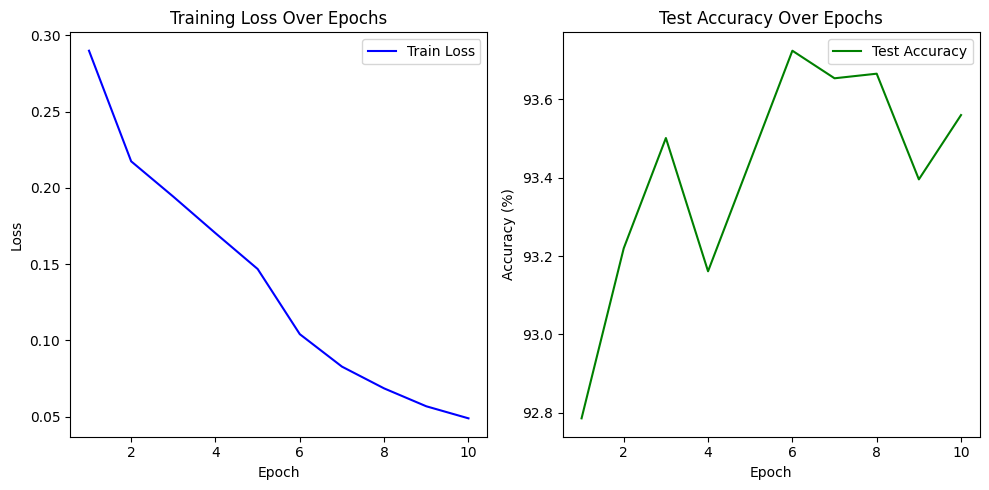

In [ ]:
import matplotlib.pyplot as plt

# Plot the training loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, color='blue', label='Train Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot the test accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), test_accuracies, color='green', label='Test Accuracy')
plt.title('Test Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()


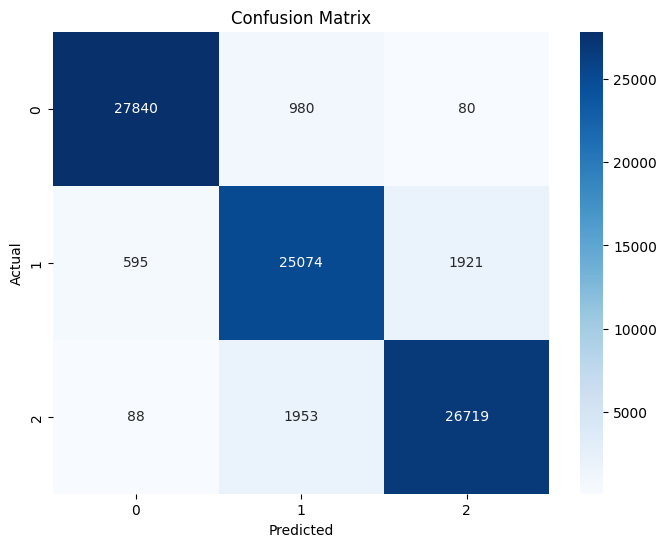

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)
cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(all_labels), yticklabels=np.unique(all_labels))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [ ]:
torch.save(model.state_dict(), 'model.pth')

Predict the Sentences

In [ ]:
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import numpy as np
import pickle

class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, num_layers=2, dropout=0.3, bidirectional=True):
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=bidirectional, dropout=dropout)
        num_directions = 2 if bidirectional else 1
        self.fc = nn.Linear(hidden_size * num_directions, num_classes)
        self.dropout = nn.Dropout(dropout)
        self.batch_norm = nn.BatchNorm1d(hidden_size * num_directions)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers * (2 if self.bidirectional else 1), batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * (2 if self.bidirectional else 1), batch_size, self.hidden_size).to(x.device)
        lstm_out, (hidden, _) = self.lstm(x, (h0, c0))
        if self.bidirectional:
            hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)
        else:
            hidden = hidden[-1]
        out = self.batch_norm(hidden)
        out = self.dropout(out)
        out = self.fc(out)
        return out

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LSTMClassifier(input_size=257, hidden_size=512, num_classes=3).to(device)
model.load_state_dict(torch.load('model.pth'))
model.eval()

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased").to(device)
bert_model.eval()

with open('pca_model.pkl', 'rb') as f:
    pca = pickle.load(f)

analyzer = SentimentIntensityAnalyzer()

def preprocess_sentence(sentence):
    tokens = tokenizer(
        [sentence],
        max_length=512,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    ).to(device)

    with torch.no_grad():
        outputs = bert_model(**tokens)
        cls_embeddings = outputs.last_hidden_state[:, 0, :]
    return cls_embeddings

def predict_sentence(sentence, pca_fitted):
    cls_embeddings = preprocess_sentence(sentence)
    cls_embeddings_np = cls_embeddings.cpu().numpy()
    pca_embeddings = pca_fitted.transform(cls_embeddings_np)
    vader_score = analyzer.polarity_scores(sentence)['compound']
    sentence_features = np.concatenate([[vader_score], pca_embeddings[0]])
    sentence_features_tensor = torch.tensor(sentence_features, dtype=torch.float32).unsqueeze(0).unsqueeze(1).to(device)
    with torch.no_grad():
        outputs = model(sentence_features_tensor)
        _, predicted = torch.max(outputs.data, 1)
    sentiment_label = predicted.item()
    sentiment = ['Negative', 'Neutral', 'Positive'][sentiment_label]
    return sentiment

The sentiment of the sentence is: Neutral
